__Regime Discovery__

- Standardize features; run K‑means (k=2–5) and Ward Linkage.
- Select k via elbow and silhouette; do stability checks.
- Profile regimes (means, smiles, timelines); save labels to Parquet.=

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from sklearn.utils import resample
from IPython.display import display
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def compute_stability(X, method, k, n_runs=5):
    scores = []
    for _ in range(n_runs):
        X_sample = resample(X, replace=True, random_state=None)
        if method == 'kmeans':
            km1 = KMeans(n_clusters=k, random_state=None, n_init=10)
            km2 = KMeans(n_clusters=k, random_state=None, n_init=10)
            labels1 = km1.fit_predict(X_sample)
            labels2 = km2.fit_predict(X_sample)
        elif method == 'ward':
            Z1 = linkage(X_sample, method='ward')
            Z2 = linkage(X_sample, method='ward')
            labels1 = fcluster(Z1, t=k, criterion='maxclust')
            labels2 = fcluster(Z2, t=k, criterion='maxclust')
        else:
            return None
        score = adjusted_rand_score(labels1, labels2)
        scores.append(score)
    return np.mean(scores)

In [3]:
def regime_discovery(ticker='SPY', method='kmeans', pca_n_components=0.5, best_k=0, compute_stabilities=True):
    
    raw_features_df = pd.read_parquet(f"{ticker}_features_parquet/", engine="pyarrow")
    print("initial dataframe")
    display(raw_features_df.sample(3))
    
    # Drop non-numeric or identifier columns
    exclude_cols = ['date', 'ticker', 'year']
    feature_cols = [col for col in raw_features_df.columns if col not in exclude_cols]
    
    # Scale features
    X = raw_features_df[feature_cols].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    original_index = raw_features_df.index.copy()
    
    if pca_n_components > 0:
        # Apply PCA to retain n_components of variance
        pca = PCA(n_components=pca_n_components)
        X_pca = pca.fit_transform(X_scaled)

        # Print explained variance and selected components
        print(f"\nPCA applied: {X_pca.shape[1]} components retained")
        print("Explained variance ratio per component:")
        display(pca.explained_variance_ratio_)

        # Print feature contributions
        components_df = pd.DataFrame(pca.components_, columns=feature_cols)
        print("\nTop contributing features per component:")
        for i, row in components_df.iterrows():
            top_features = row.abs().sort_values(ascending=False).head(5).index.tolist()
            print(f"Component {i+1}: {top_features}")

        # Replace features_df with PCA-transformed data
        features_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
        features_df.index = original_index
        print("after applying pca")
        display(features_df.sample(3))

    else:
        # Use scaled original features
        features_df = pd.DataFrame(X_scaled, columns=feature_cols)
    
    features_df.index = original_index
    X_cluster = features_df.values  # use PCA or scaled features
    K_range = range(2, 6)
    silhouettes = []
    stabilities = []
    inertias = None
    labels = None

    print(f"\nResults {'PCA_' + str(pca_n_components) if pca_n_components > 0 else 'without'} PCA using {method.upper()} clustering")
    print("=================================================")

    if method == 'kmeans':
        inertias = []
        if best_k > 0:
            km = KMeans(n_clusters=best_k, random_state=42, n_init=10)
            labels = km.fit_predict(X_cluster)
            inertias.append(km.inertia_)
            silhouettes.append(silhouette_score(X_cluster, labels))
            if compute_stabilities:
                stabilities.append(compute_stability(X_cluster, method='kmeans', k=best_k))            
            # Internal metrics
            print("K-means Silhouette:", silhouette_score(X_cluster, labels))
            print("K-means CH Index:", calinski_harabasz_score(X_cluster, labels))
            print("K-means DB Index:", davies_bouldin_score(X_cluster, labels))
        else:
            for k in K_range:
                km = KMeans(n_clusters=k, random_state=42, n_init=10)
                labels = km.fit_predict(X_cluster)
                inertias.append(km.inertia_)
                silhouettes.append(silhouette_score(X_cluster, labels))
                if compute_stabilities:
                    stabilities.append(compute_stability(X_cluster, method='kmeans', k=k))

            fig, ax = plt.subplots(1, 2, figsize=(12, 4))
            ax[0].plot(K_range, inertias, marker='o')
            ax[0].set_title("Elbow Method (Inertia)")
            ax[0].set_xlabel("Number of clusters (k)")
            ax[0].set_ylabel("Inertia")

            ax[1].plot(K_range, silhouettes, marker='o', label='Silhouette')
            ax[1].plot(K_range, stabilities, marker='x', label='Stability')
            ax[1].set_title("Silhouette vs Stability")
            ax[1].set_xlabel("Number of clusters (k)")
            ax[1].set_ylabel("Score")
            ax[1].legend()
            plt.show()

    elif method == 'ward':
        Z = linkage(X_cluster, method='ward')
        plt.figure(figsize=(10, 5))
        dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10.)
        plt.title("Hierarchical Clustering Dendrogram (Ward linkage)")
        plt.xlabel("Cluster size")
        plt.ylabel("Distance")
        plt.show()
        
        if best_k > 0:
            labels = fcluster(Z, t=3, criterion='maxclust')
            # Internal metrics
            print("Ward Silhouette:", silhouette_score(X_cluster, labels))
            print("Ward CH Index:", calinski_harabasz_score(X_cluster, labels))
            print("Ward DB Index:", davies_bouldin_score(X_cluster, labels))

        if compute_stabilities:
            for k in K_range:
                labels = fcluster(Z, t=k, criterion='maxclust')
                silhouettes.append(silhouette_score(X_cluster, labels))
                stabilities.append(compute_stability(X_cluster, method='ward', k=k))

            plt.figure(figsize=(6, 4))
            plt.plot(K_range, silhouettes, marker='o', label='Silhouette')
            plt.plot(K_range, stabilities, marker='x', label='Stability')
            plt.title("Silhouette vs Stability (Ward)")
            plt.xlabel("Number of clusters (k)")
            plt.ylabel("Score")
            plt.legend()
            plt.show()
            
            
    else:
        print("only 'kmeans' and 'ward' are supported method values")

    return {
        "ticker": ticker,
        "method": method,
        "nComponents": pca_n_components,
        "features": features_df,
        "raw_features": raw_features_df,
        "inertias": inertias,
        "silhouettes": silhouettes,
        "stabilities": stabilities,
        "labels": labels if best_k > 0 else None
    }


Running KMEANS with no PCA
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
231,2023-05-22,SPY,0.147780,0.076051,0.022615,0.128745,0.091128,55.104210,-20.847578,0.030692,...,0.153885,0.250983,0.426961,1.669508,4.523705,7.178584,7.668906,8.654180,10.949725,2023
77,2023-05-17,SPY,0.162616,0.066364,0.011139,0.131244,0.045886,55.684223,-19.222896,0.472608,...,2.381907,3.403142,3.721490,3.203460,3.267480,3.527440,4.075260,4.833764,7.915816,2023
187,2023-03-20,SPY,0.196755,0.097487,0.010385,0.117267,-0.015006,56.530034,-28.738040,0.333436,...,1.687945,2.279320,1.817327,0.999006,3.208256,2.589156,-1.881177,-8.561707,-10.785670,2023



Results without PCA using KMEANS clustering


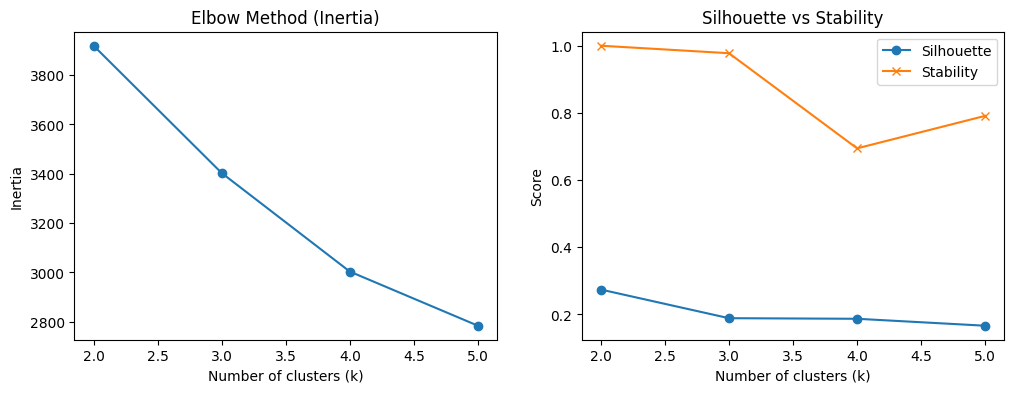


Running KMEANS with PCA_0.3
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
116,2023-07-14,SPY,0.129518,0.051760,0.005354,0.111856,0.103204,63.984397,-15.017448,0.022003,...,0.116626,0.411395,1.661769,4.424971,7.679984,9.518438,10.959791,16.102715,22.820644,2023
71,2023-05-09,SPY,0.150750,0.089886,0.034156,0.114579,0.063130,54.822456,-23.854609,-0.173116,...,-0.873873,-1.220473,-1.200481,0.468646,1.875801,-0.193544,-1.141597,1.232711,5.477258,2023
81,2023-05-23,SPY,0.175249,0.085071,-0.003644,0.128072,0.072176,56.428787,-22.873608,-0.494212,...,-2.492674,-3.622037,-4.256108,-4.084084,-1.858843,1.259070,2.584910,3.790220,5.410458,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.46512817])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
279,0.061794
191,0.479767
298,1.428564



Results PCA_0.3 PCA using KMEANS clustering


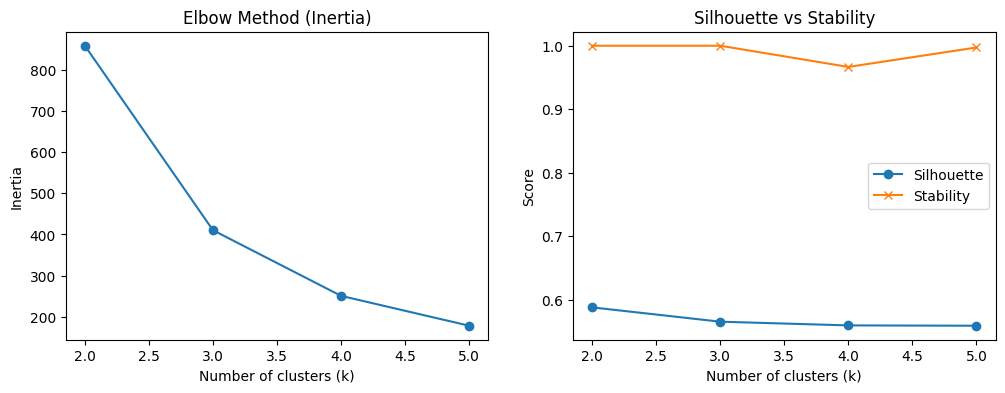


Running KMEANS with PCA_0.5
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
136,2023-08-11,SPY,0.150804,0.031438,-0.012644,0.107631,0.048506,63.255136,-18.450726,-0.041218,...,-0.207012,-0.339932,-0.593152,-1.576518,-3.102329,-4.972791,-6.514065,-3.968798,4.250095,2023
300,2023-08-30,SPY,0.130191,0.090684,0.020030,0.125074,0.100082,58.059644,-18.884124,0.260169,...,1.311460,2.317515,4.728236,8.355307,10.705989,11.563302,9.308670,4.345032,3.935210,2023
152,2023-01-27,SPY,0.169643,0.045341,0.004586,0.028740,0.208017,61.582100,-34.368343,0.034333,...,0.271046,0.466200,0.883475,2.941903,5.392253,5.338765,15.829108,9.301969,24.336340,2023



PCA applied: 2 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
after applying pca


,PC1,PC2
161,-3.371090,0.837629
140,-5.440048,0.038897
284,-1.462551,0.857664



Results PCA_0.5 PCA using KMEANS clustering


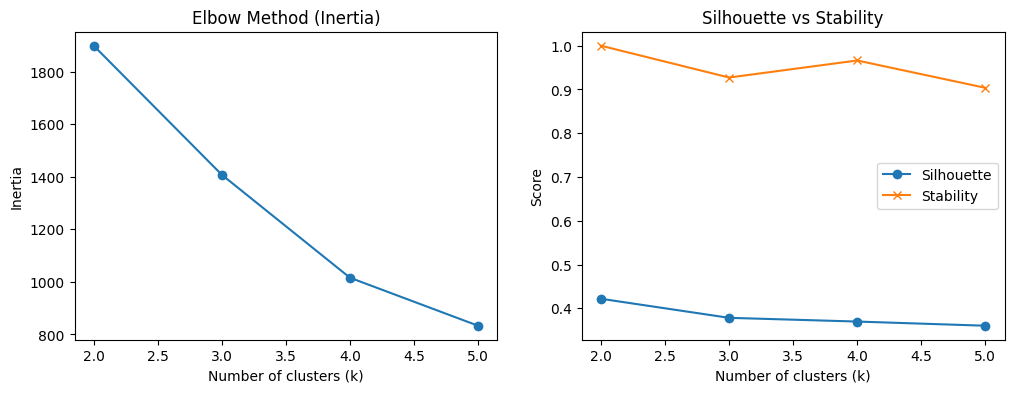


Running KMEANS with PCA_0.7
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
168,2023-02-21,SPY,0.198838,0.057641,0.005732,0.094673,0.023210,56.794123,-28.046176,-0.704191,...,-3.687004,-5.680199,-8.114228,-10.262262,-12.906166,-12.122183,-11.225803,-8.934485,2.443597,2023
52,2023-04-12,SPY,0.177112,0.090844,0.015222,0.104184,0.014382,58.113585,-21.033050,-0.165033,...,-0.833797,-1.219725,-1.466381,-1.263686,-0.587984,1.255530,5.912435,13.354490,12.491492,2023
134,2023-08-09,SPY,0.149261,0.059507,0.004295,0.125024,0.089134,57.159853,-23.362387,-0.314171,...,-1.579987,-2.413873,-3.415996,-3.645897,-3.794982,-6.483873,-8.280695,-3.324322,5.991431,2023



PCA applied: 3 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398, 0.08383526])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
Component 3: ['Curvature', 'Skew', 'ATM_IV', 'IV_std', 'Avg_Theta']
after applying pca


,PC1,PC2,PC3
174,-3.818570,-2.850211,-0.151101
118,4.405405,1.437600,0.746063
294,-2.153069,-1.451665,-2.163250



Results PCA_0.7 PCA using KMEANS clustering


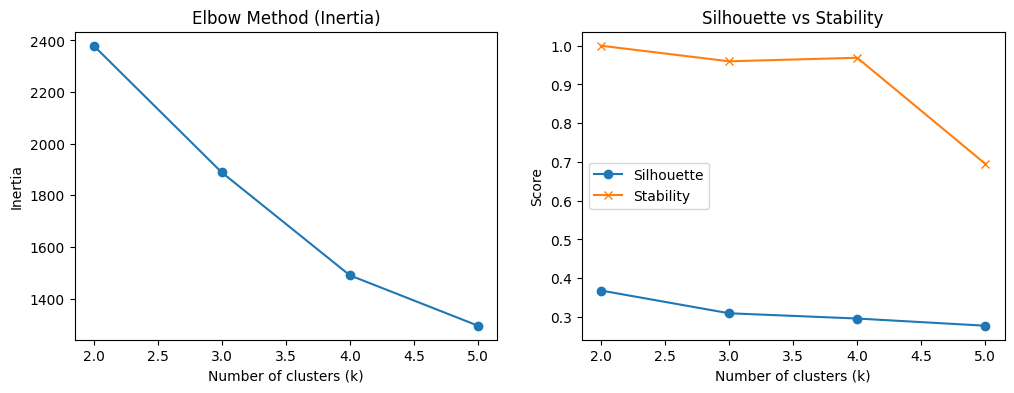


Running KMEANS with PCA_0.9
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
216,2023-05-01,SPY,0.130835,0.018580,0.015066,0.128836,0.103863,58.381394,-22.391914,0.009736,...,0.054241,0.305607,1.463829,4.948641,6.692661,5.030987,4.157114,7.827183,14.530855,2023
268,2023-07-17,SPY,0.125513,0.045329,0.014337,0.146606,0.154973,59.658743,-16.802449,0.180539,...,0.907442,1.388960,1.985820,3.337150,6.762268,10.432215,12.308579,16.471454,23.201885,2023
175,2023-03-02,SPY,0.183196,0.068547,0.005019,0.105526,-0.014346,51.843276,-23.995158,0.293095,...,1.494644,2.139162,2.320493,1.360944,-0.083615,-2.477327,-8.005192,-13.166251,-6.212973,2023



PCA applied: 7 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398, 0.08383526, 0.06898744, 0.04943558,
       0.04677694, 0.0362115 ])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
Component 3: ['Curvature', 'Skew', 'ATM_IV', 'IV_std', 'Avg_Theta']
Component 4: ['IV_std', 'Avg_Theta', 'Skew', 'ATM_IV', 'Curvature']
Component 5: ['Avg_Theta', 'Avg_Delta', 'Avg_Vega', 'IV_std', 'price_diff_55d']
Component 6: ['IV_std', 'Avg_Vega', 'Avg_Theta', 'price_diff_34d', 'price_diff_55d']
Component 7: ['Avg_Vega', 'IV_std', 'Skew', 'Curvature', 'ATM_IV']
after applying pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
112,0.205150,0.012032,-1.676951,1.322867,0.891194,-0.722384,-0.041051
271,-0.479512,3.120265,0.231070,2.404326,0.120650,2.097539,0.317863
63,3.684281,-3.630974,-0.772333,0.104564,-0.323142,-0.956687,0.322560



Results PCA_0.9 PCA using KMEANS clustering


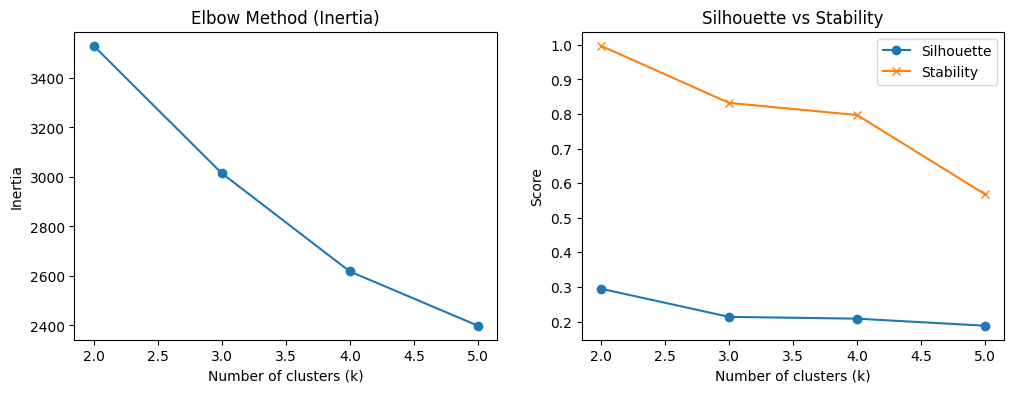


Running WARD with no PCA
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
136,2023-08-11,SPY,0.150804,0.031438,-0.012644,0.107631,0.048506,63.255136,-18.450726,-0.041218,...,-0.207012,-0.339932,-0.593152,-1.576518,-3.102329,-4.972791,-6.514065,-3.968798,4.250095,2023
209,2023-04-20,SPY,0.159266,0.077128,0.014312,0.177724,0.034421,58.018087,-22.502624,-0.226108,...,-1.138609,-1.677645,-2.085412,-1.899827,-0.991941,1.369051,4.438584,9.880932,16.248005,2023
62,2023-04-26,SPY,0.177792,0.082385,0.012842,0.119802,0.064053,57.933492,-25.252337,-0.232853,...,-1.175195,-2.108227,-4.440449,-6.942097,-8.284879,-8.185073,-6.202883,-0.698950,5.765638,2023



Results without PCA using WARD clustering


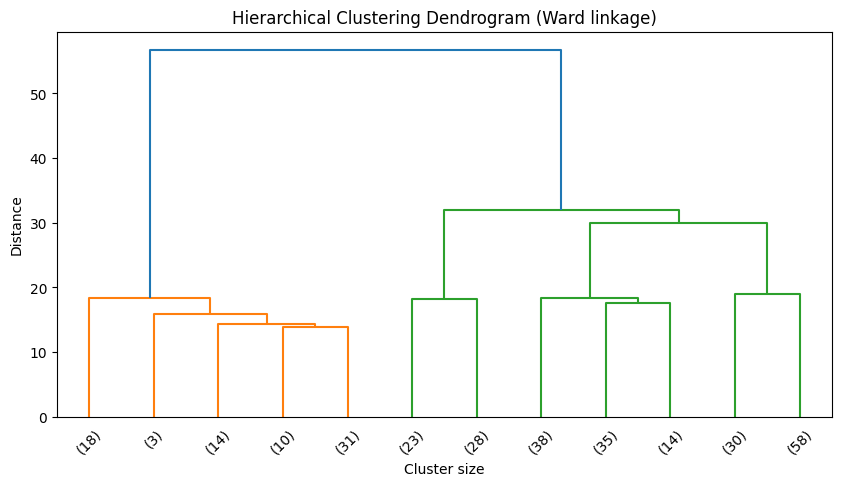

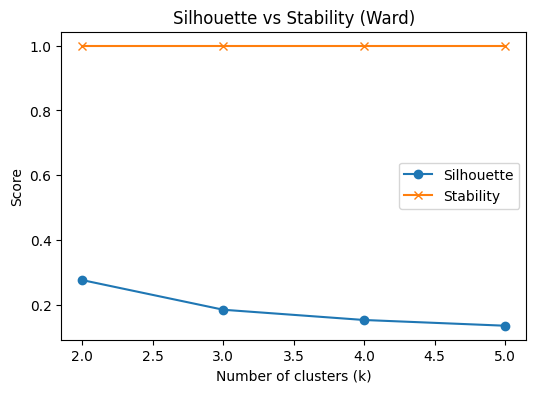


Running WARD with PCA_0.3
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
77,2023-05-17,SPY,0.162616,0.066364,0.011139,0.131244,0.045886,55.684223,-19.222896,0.472608,...,2.381907,3.403142,3.721490,3.203460,3.267480,3.527440,4.075260,4.833764,7.915816,2023
127,2023-07-31,SPY,0.158974,0.036305,-0.014325,0.110644,0.118824,61.476314,-16.410345,0.139688,...,0.712076,1.240641,2.448084,3.657492,3.955592,4.957769,8.866915,15.671092,24.376134,2023
165,2023-02-15,SPY,0.170472,0.070183,0.012381,0.113899,0.080182,55.924882,-25.367252,0.119943,...,0.624201,0.948515,1.303468,2.238503,4.568437,3.988257,2.455234,10.191214,20.291055,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.46512817])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
61,-5.462540
73,-0.924345
176,3.349321



Results PCA_0.3 PCA using WARD clustering


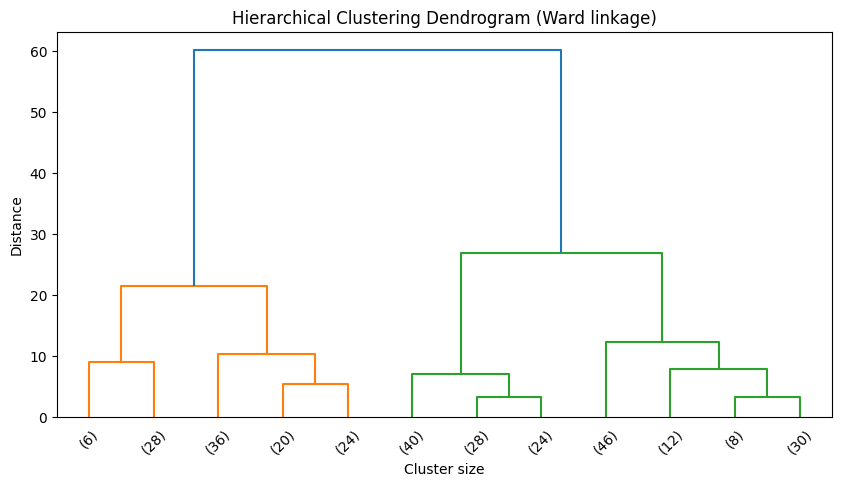

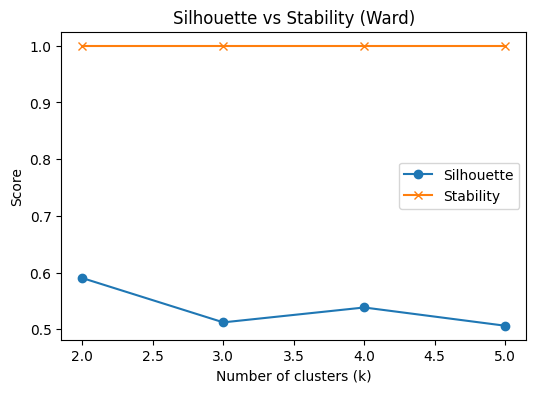


Running WARD with PCA_0.5
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
115,2023-07-13,SPY,0.123555,0.036939,-0.001303,0.143103,0.175174,60.001251,-20.734341,0.413566,...,2.078495,3.296273,5.225458,7.688420,9.540372,9.799782,11.689892,17.090150,23.758504,2023
0,2023-01-26,SPY,0.167133,0.049611,0.008268,0.023395,0.200213,62.394852,-36.756860,0.000000,...,0.000000,0.000000,3.519992,4.399990,4.549990,7.920000,13.260010,9.230010,23.929990,2023
208,2023-04-19,SPY,0.165232,0.088787,0.001350,0.171643,0.069697,54.167343,-21.005847,0.001462,...,0.007531,0.044612,0.215197,0.854119,2.420600,4.175073,7.129411,12.529919,18.854020,2023



PCA applied: 2 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
after applying pca


,PC1,PC2
244,1.944769,1.509784
211,-0.146878,-0.454962
197,3.339386,1.226364



Results PCA_0.5 PCA using WARD clustering


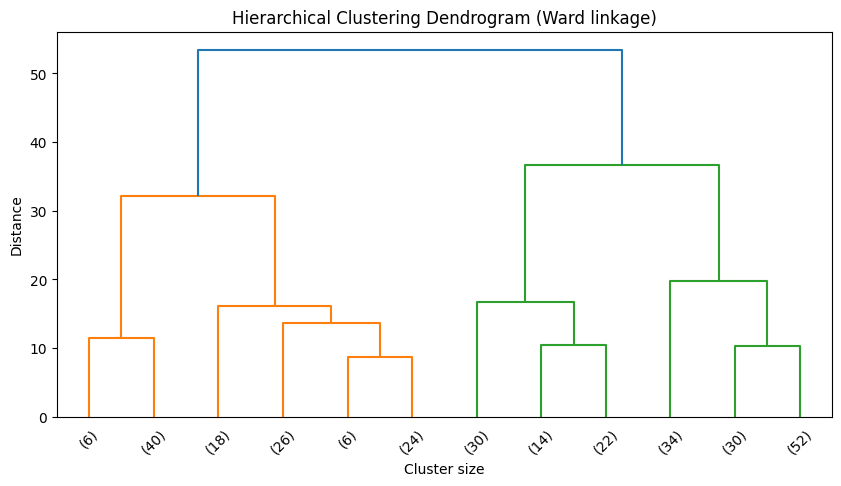

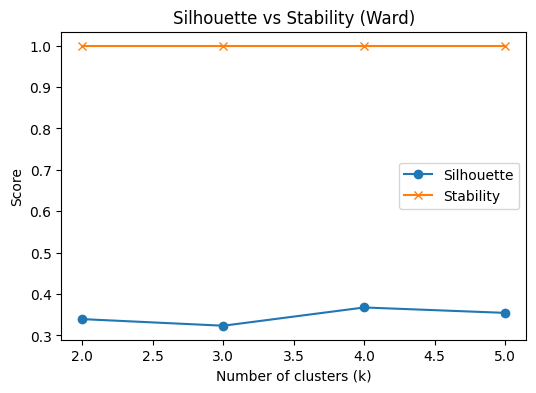


Running WARD with PCA_0.7
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
161,2023-02-09,SPY,0.198369,0.051710,-0.003454,0.093533,0.103340,57.352583,-34.187143,-0.292689,...,-1.536195,-2.480037,-4.156322,-6.014062,-5.180254,-5.500936,1.275568,7.862213,14.619555,2023
199,2023-04-05,SPY,0.159746,0.063211,0.022836,0.122037,0.074700,59.390556,-23.822541,-0.118114,...,-0.595252,-0.972394,-1.667891,-1.884624,1.166379,7.864927,12.782707,13.289711,10.757340,2023
114,2023-07-12,SPY,0.127204,0.042548,-0.003522,0.113556,0.110548,60.259389,-15.713638,0.415541,...,2.095685,3.238487,4.752992,6.049657,6.202067,6.099549,9.221766,14.002861,21.327385,2023



PCA applied: 3 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398, 0.08383526])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
Component 3: ['Curvature', 'Skew', 'ATM_IV', 'IV_std', 'Avg_Theta']
after applying pca


,PC1,PC2,PC3
275,1.341080,1.758880,2.304891
228,2.313351,-2.190130,0.838925
151,1.519572,2.139138,-1.789137



Results PCA_0.7 PCA using WARD clustering


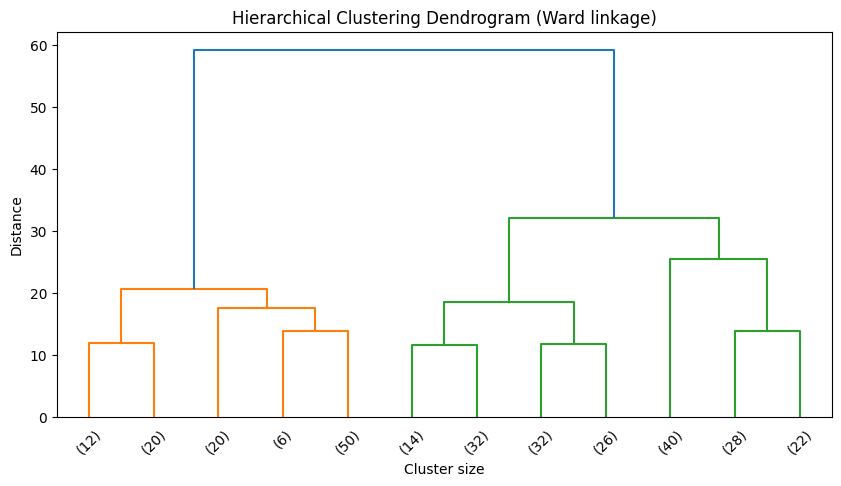

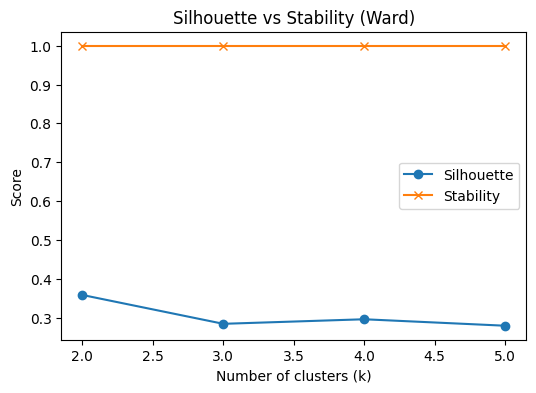


Running WARD with PCA_0.9
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
45,2023-03-31,SPY,0.179259,0.068097,-0.000667,0.102485,0.140814,65.728481,-22.302712,0.565150,...,2.852265,4.428520,6.617660,9.488044,12.667228,14.281535,16.190340,15.043070,7.845767,2023
147,2023-08-28,SPY,0.135827,0.059989,0.019083,0.123055,0.070800,57.146223,-17.893522,0.325629,...,1.635977,2.524399,3.695307,3.035148,2.792763,2.905810,-0.494044,-5.473939,-3.006633,2023
139,2023-08-16,SPY,0.155578,0.079535,0.013920,0.159100,0.119714,58.957987,-29.431195,-0.385736,...,-1.945570,-3.146760,-5.262927,-6.776151,-7.228058,-8.147179,-10.694809,-10.901806,-2.776584,2023



PCA applied: 7 components retained
Explained variance ratio per component:


array([0.46512817, 0.18166398, 0.08383526, 0.06898744, 0.04943558,
       0.04677694, 0.0362115 ])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'Avg_Delta', 'price_diff_144d', 'price_diff_89d', 'ATM_IV']
Component 3: ['Curvature', 'Skew', 'ATM_IV', 'IV_std', 'Avg_Theta']
Component 4: ['IV_std', 'Avg_Theta', 'Skew', 'ATM_IV', 'Curvature']
Component 5: ['Avg_Theta', 'Avg_Delta', 'Avg_Vega', 'IV_std', 'price_diff_55d']
Component 6: ['IV_std', 'Avg_Vega', 'Avg_Theta', 'price_diff_34d', 'price_diff_55d']
Component 7: ['Avg_Vega', 'IV_std', 'Skew', 'Curvature', 'ATM_IV']
after applying pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
154,2.815195,-0.108103,-1.804276,-2.681854,-2.188152,-0.145836,-1.097671
135,-1.517495,0.024133,1.000165,0.468705,-1.760817,-1.153721,-0.254154
207,0.841909,0.809101,1.017252,-0.252228,-0.165735,0.634192,0.602681



Results PCA_0.9 PCA using WARD clustering


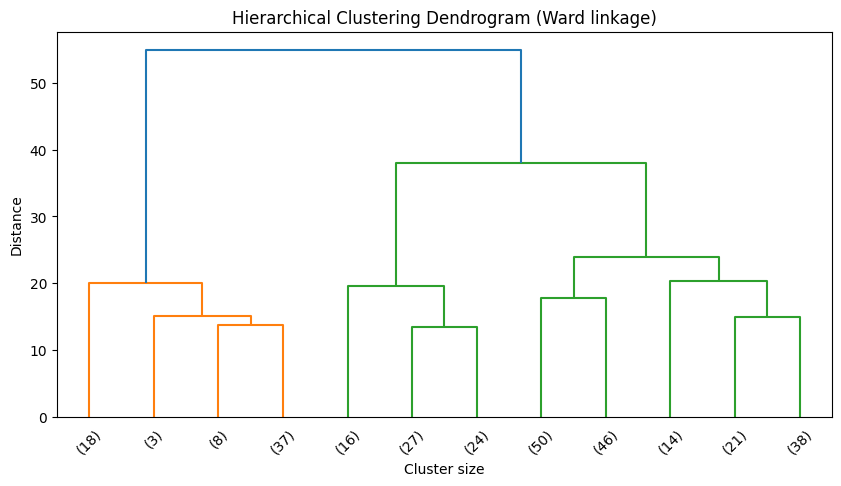

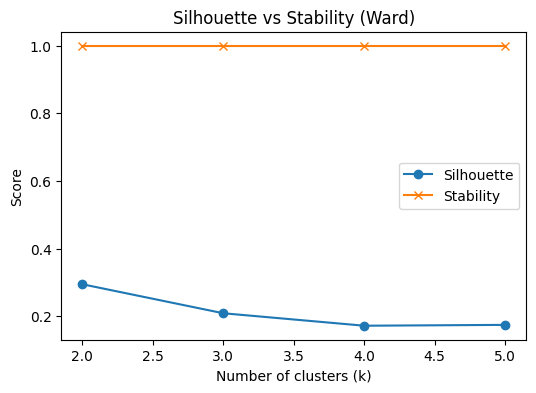


Running KMEANS with no PCA
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
34,2023-03-27,QQQ,0.244271,0.085492,0.002222,0.085440,0.061356,46.728980,-25.807279,-0.280399,...,-1.413611,-1.486297,-0.808325,0.276049,1.626221,7.622796,14.422250,10.744474,11.321733,2023
177,2023-03-24,QQQ,0.244979,0.081141,0.004516,0.086294,0.086405,46.045868,-26.573404,0.167534,...,0.845183,1.714749,2.665346,3.642897,5.083118,10.984413,17.802499,13.005996,13.290250,2023
65,2023-05-10,QQQ,0.215655,0.102736,0.001702,0.090894,0.077675,43.164376,-20.768626,0.448293,...,2.261599,2.713071,2.990946,3.922486,6.361751,6.592007,9.117162,10.477661,18.409465,2023



Results without PCA using KMEANS clustering


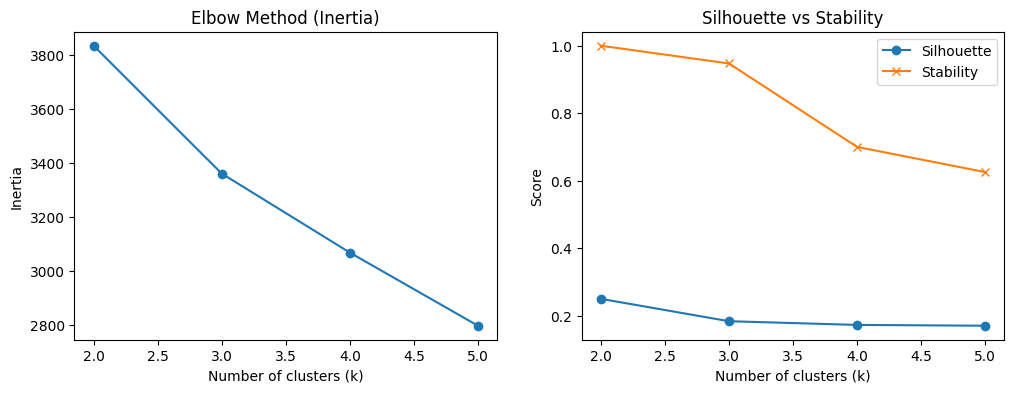


Running KMEANS with PCA_0.3
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
114,2023-07-21,QQQ,0.177827,0.046715,0.013020,0.098595,0.161048,47.959330,-21.007489,-0.256958,...,-1.295606,-2.940079,-5.853199,-7.986678,-3.879160,2.883740,10.818692,17.054464,30.587377,2023
259,2023-07-24,QQQ,0.187780,0.066771,0.012315,0.098717,0.144937,48.602742,-22.414481,0.025911,...,0.124485,-0.417651,-1.843620,-4.352699,-5.464198,1.417498,10.732263,16.120709,28.917916,2023
63,2023-05-08,QQQ,0.210743,0.072967,0.009962,0.083499,0.048076,44.669251,-21.910469,0.172692,...,0.871755,2.214543,4.505504,5.982261,4.267484,5.407337,8.260641,9.118056,17.512102,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.43664298])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
3,-2.275163
216,1.677305
257,-3.741684



Results PCA_0.3 PCA using KMEANS clustering


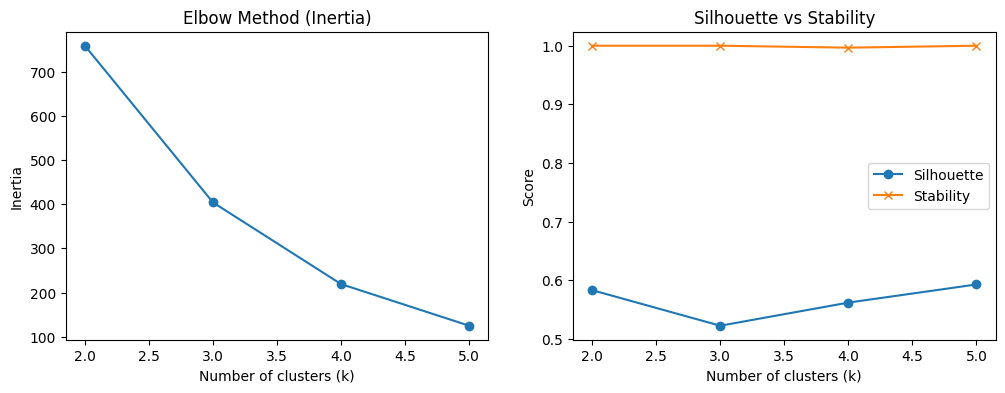


Running KMEANS with PCA_0.5
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
151,2023-02-15,QQQ,0.230453,0.065755,0.007218,0.102142,0.175073,44.921794,-23.948038,0.279689,...,1.479694,2.219723,3.683294,6.575931,7.228922,1.954519,6.657002,21.881253,38.578119,2023
222,2023-05-30,QQQ,0.217429,0.043008,-0.010305,0.096531,0.185333,47.141045,-22.611918,0.262342,...,1.320346,3.218943,7.650409,13.870807,16.282008,17.725359,26.343992,32.336018,39.658905,2023
92,2023-06-20,QQQ,0.201377,0.040572,0.001299,0.122223,0.215908,46.137261,-24.663112,-0.128561,...,-0.646970,-0.990693,-1.082512,0.735289,6.606005,14.224923,18.757087,32.950018,49.527532,2023



PCA applied: 2 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
after applying pca


,PC1,PC2
78,4.002971,1.864074
138,-5.508160,0.121334
3,-2.275163,1.234187



Results PCA_0.5 PCA using KMEANS clustering


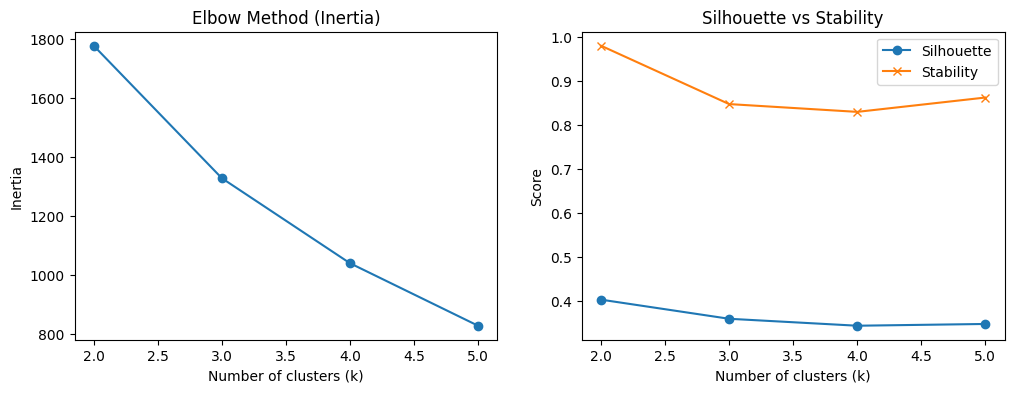


Running KMEANS with PCA_0.7
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
70,2023-05-17,QQQ,0.194921,0.065997,0.011705,0.131752,0.135031,43.952337,-21.770551,0.527940,...,2.667119,3.661423,4.679495,5.610404,7.129663,10.245846,13.605106,16.718165,22.197151,2023
51,2023-04-20,QQQ,0.215537,0.079704,0.011602,0.123035,0.028949,43.343150,-24.444146,-0.347288,...,-1.748927,-2.171887,-2.430021,-2.280971,-1.363669,0.277140,1.585468,10.764976,18.911875,2023
266,2023-08-02,QQQ,0.201173,0.044342,0.001176,0.139946,0.176692,50.491358,-27.952527,-1.115441,...,-5.616279,-7.083678,-7.786547,-6.519686,-3.626860,-2.492074,0.194969,11.646872,26.158051,2023



PCA applied: 3 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582, 0.09110721])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
Component 3: ['ATM_IV', 'Avg_Vega', 'Avg_Theta', 'Skew', 'price_diff_55d']
after applying pca


,PC1,PC2,PC3
133,-6.332769,-0.939719,-0.350389
48,-0.218600,-0.516584,0.607159
179,-1.989572,-0.215920,1.181244



Results PCA_0.7 PCA using KMEANS clustering


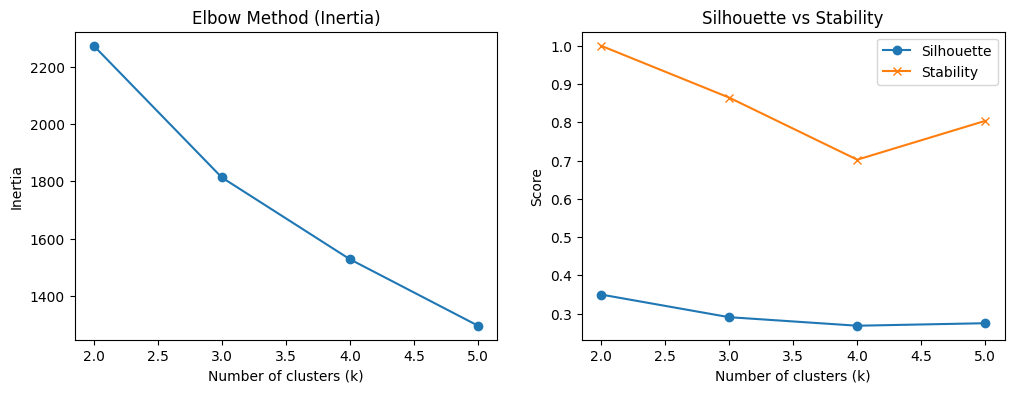


Running KMEANS with PCA_0.9
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
10,2023-02-21,QQQ,0.258878,0.078140,-0.007965,0.061258,0.121902,45.650457,-37.279617,-0.781691,...,-4.046437,-6.064160,-8.289268,-11.217472,-12.590773,-7.825963,-12.101774,2.579954,18.895863,2023
86,2023-06-09,QQQ,0.180421,0.077899,0.025819,0.090351,0.139428,47.108623,-20.111796,0.238129,...,1.200761,2.015615,2.870898,2.687435,1.808420,7.464489,17.954357,28.956473,40.637252,2023
58,2023-05-01,QQQ,0.182541,0.066690,0.030313,0.077776,0.114579,46.330634,-23.246692,-0.002638,...,-0.013503,0.667854,2.734385,6.494249,8.368595,4.936805,5.618948,9.971335,21.174205,2023



PCA applied: 7 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582, 0.09110721, 0.06875528, 0.05801068,
       0.04839402, 0.04119557])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
Component 3: ['ATM_IV', 'Avg_Vega', 'Avg_Theta', 'Skew', 'price_diff_55d']
Component 4: ['Skew', 'Curvature', 'Avg_Theta', 'IV_std', 'Avg_Delta']
Component 5: ['Curvature', 'IV_std', 'Avg_Theta', 'Avg_Delta', 'Avg_Vega']
Component 6: ['IV_std', 'ATM_IV', 'Curvature', 'Avg_Delta', 'Skew']
Component 7: ['Avg_Vega', 'Avg_Theta', 'price_diff_34d', 'price_diff_233d', 'Curvature']
after applying pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
91,1.580069,4.085961,-0.132549,0.324492,-1.556822,-0.689936,0.380089
9,-2.683591,0.221340,0.215130,0.053065,-0.180651,-1.681143,-0.164956
145,3.384975,1.634526,0.888265,-1.495762,2.664860,-2.129728,1.128996



Results PCA_0.9 PCA using KMEANS clustering


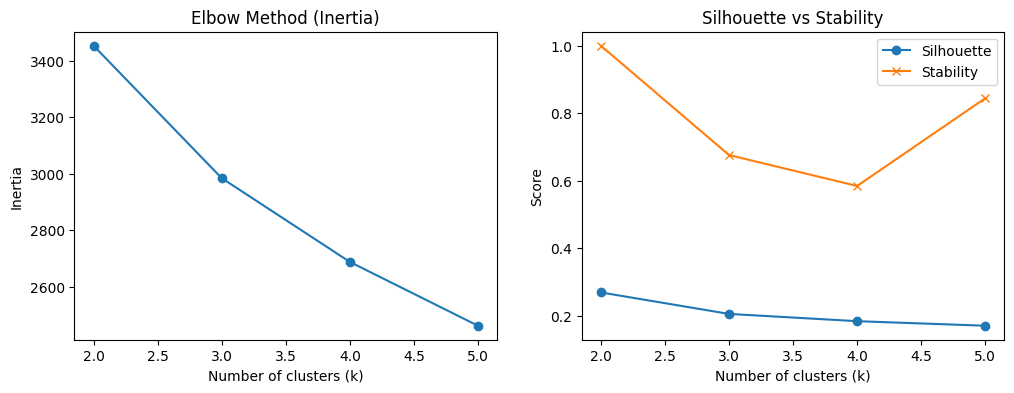


Running WARD with no PCA
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
107,2023-07-12,QQQ,0.184356,0.054579,0.004159,0.085041,0.135906,49.117944,-18.836652,0.693074,...,3.484558,4.637579,5.709133,5.914028,5.674626,6.876639,11.805801,18.238942,38.510195,2023
14,2023-02-27,QQQ,0.246498,0.064177,0.002779,0.046969,0.033596,43.117009,-30.071653,0.237861,...,1.210332,1.101982,-0.196362,-1.752557,-2.427186,-10.764864,-9.485886,-6.780503,15.683458,2023
8,2023-02-16,QQQ,0.238218,0.066728,0.004587,0.132267,0.216189,40.895076,-34.991546,-0.604151,...,-3.159843,-4.329055,-4.376605,-1.974768,1.659503,-2.322037,-0.982210,14.385111,31.384557,2023



Results without PCA using WARD clustering


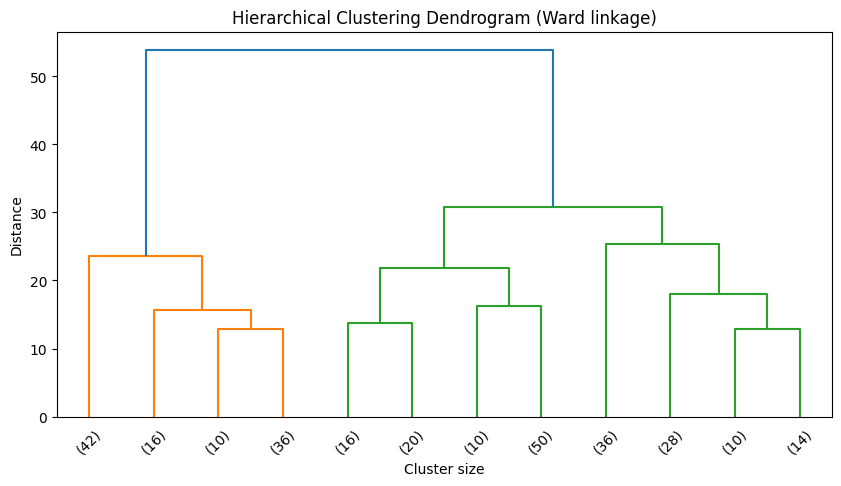

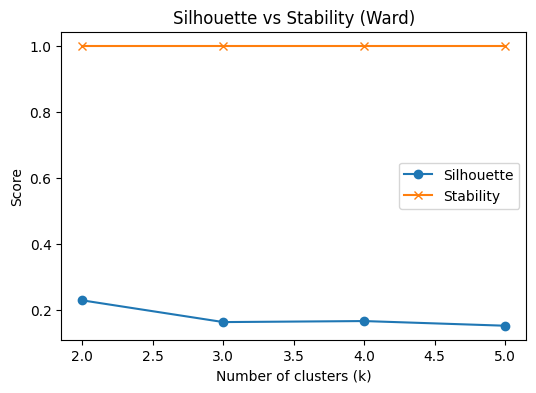


Running WARD with PCA_0.3
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
34,2023-03-27,QQQ,0.244271,0.085492,0.002222,0.085440,0.061356,46.728980,-25.807279,-0.280399,...,-1.413611,-1.486297,-0.808325,0.276049,1.626221,7.622796,14.422250,10.744474,11.321733,2023
146,2023-02-08,QQQ,0.242024,0.062877,0.003723,0.115207,0.271583,42.452722,-32.207140,-0.479933,...,-2.676549,-4.223183,-3.687270,0.424256,-4.279341,8.187435,12.437602,26.264322,39.822163,2023
273,2023-08-11,QQQ,0.197386,0.065661,0.008520,0.098927,0.057734,49.804440,-22.428747,-0.356599,...,-1.799975,-2.364838,-3.297444,-5.342542,-8.554093,-10.481242,-11.723646,-5.145110,10.639743,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.43664298])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
101,2.019498
218,-1.981313
52,-1.176093



Results PCA_0.3 PCA using WARD clustering


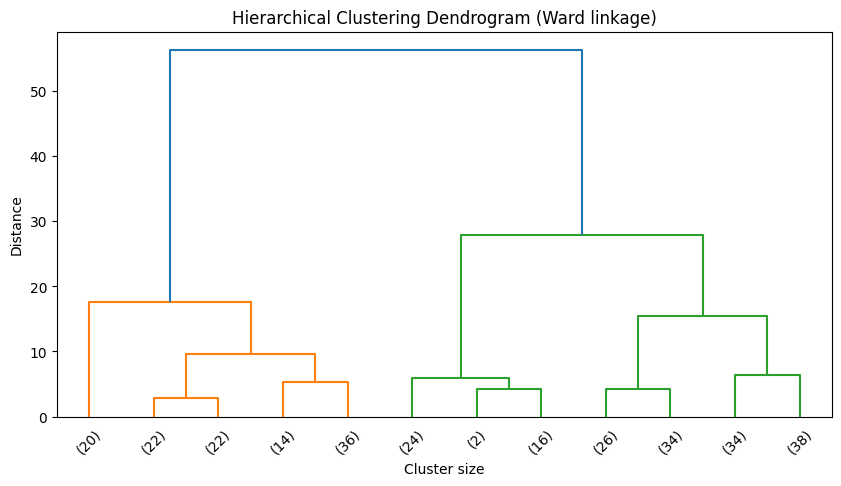

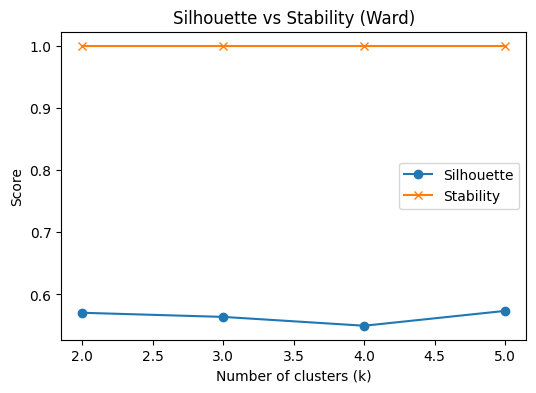


Running WARD with PCA_0.5
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
25,2023-03-14,QQQ,0.247792,0.061659,0.003582,0.102142,0.068867,43.759286,-30.245476,0.884276,...,4.477074,6.082615,7.067737,5.442369,0.787086,0.529922,2.217404,-4.220904,4.049811,2023
139,2023-08-25,QQQ,0.201329,0.059178,0.008721,0.088055,0.084760,49.334241,-22.023899,0.325412,...,1.635935,0.594058,-0.884079,-0.955895,1.236469,-1.206122,-7.630261,-9.033917,0.088458,2023
93,2023-06-21,QQQ,0.206397,0.037083,-0.007999,0.105589,0.177386,46.612118,-22.147481,-0.703905,...,-3.530184,-4.598675,-5.489392,-5.281631,-1.479702,6.270389,14.053820,25.860059,43.806586,2023



PCA applied: 2 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
after applying pca


,PC1,PC2
162,2.101596,-3.259454
168,-2.242989,-3.977115
122,-5.188366,3.429423



Results PCA_0.5 PCA using WARD clustering


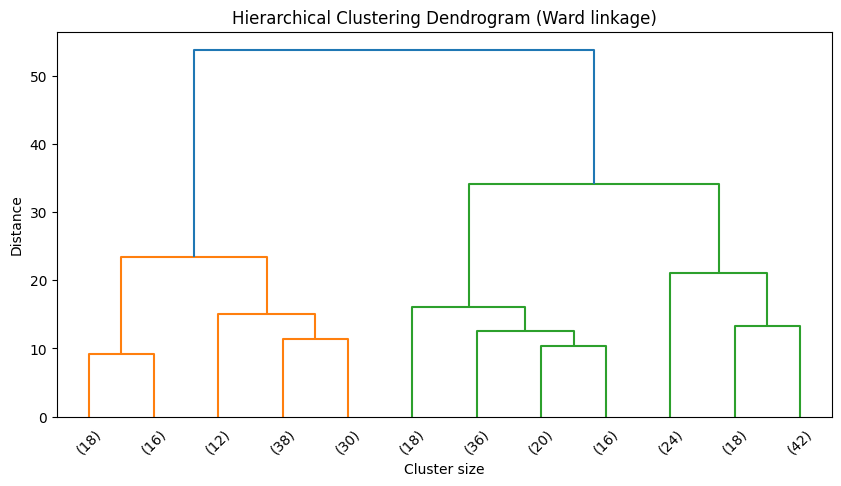

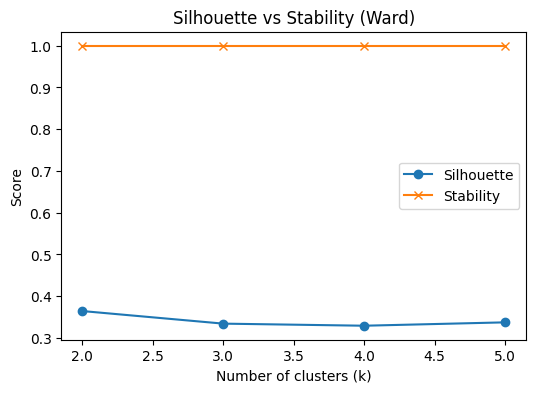


Running WARD with PCA_0.7
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
68,2023-05-15,QQQ,0.211365,0.061609,-0.002284,0.101919,0.083024,42.638537,-20.750729,0.242409,...,1.221141,1.417552,1.604941,2.402176,4.936210,6.858371,8.727168,11.991505,18.558443,2023
57,2023-04-28,QQQ,0.192480,0.069728,0.011092,0.071725,0.085627,47.998660,-20.317749,0.376451,...,1.909376,3.937223,7.384228,9.697434,6.924185,5.027507,5.992071,10.899324,21.613428,2023
140,2023-08-28,QQQ,0.183887,0.060150,0.019776,0.090548,0.084217,46.154066,-23.217697,0.417286,...,2.097029,2.938633,3.090071,2.505792,2.845884,2.487129,-3.983598,-6.303289,2.153052,2023



PCA applied: 3 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582, 0.09110721])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
Component 3: ['ATM_IV', 'Avg_Vega', 'Avg_Theta', 'Skew', 'price_diff_55d']
after applying pca


,PC1,PC2,PC3
143,2.030895,-0.455265,-0.695035
285,4.883972,-3.271804,-2.081343
198,-5.486013,0.455182,0.198340



Results PCA_0.7 PCA using WARD clustering


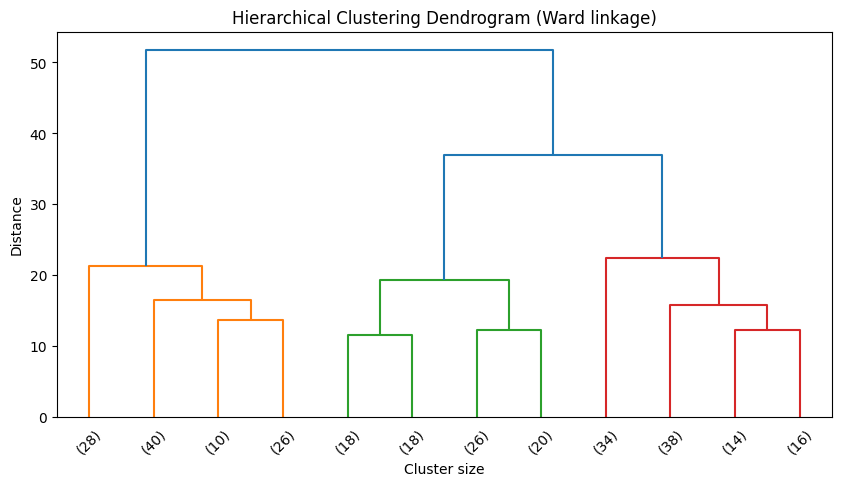

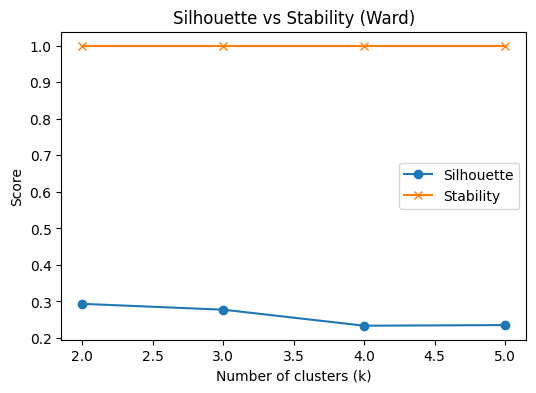


Running WARD with PCA_0.9
initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
190,2023-04-13,QQQ,0.213305,0.061751,0.010338,0.085004,0.066433,45.287106,-20.804982,0.787336,...,3.978578,4.451163,3.827614,2.049589,1.456347,2.861927,9.890226,17.375485,23.074309,2023
77,2023-05-26,QQQ,0.204064,0.059222,0.007311,0.104972,0.199138,47.552400,-22.127381,1.184281,...,5.950120,9.109243,12.960244,15.157635,13.951322,18.136624,25.665606,31.718952,38.521574,2023
153,2023-02-17,QQQ,0.232914,0.071386,0.004417,0.041456,0.164915,46.436514,-27.192597,-0.237078,...,-1.231913,-2.217276,-4.586832,-6.758867,-2.908692,-1.995848,-3.448528,10.483538,27.387651,2023



PCA applied: 7 components retained
Explained variance ratio per component:


array([0.43664298, 0.18638582, 0.09110721, 0.06875528, 0.05801068,
       0.04839402, 0.04119557])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
Component 2: ['price_diff_233d', 'price_diff_144d', 'Avg_Delta', 'price_diff_89d', 'price_diff_5d']
Component 3: ['ATM_IV', 'Avg_Vega', 'Avg_Theta', 'Skew', 'price_diff_55d']
Component 4: ['Skew', 'Curvature', 'Avg_Theta', 'IV_std', 'Avg_Delta']
Component 5: ['Curvature', 'IV_std', 'Avg_Theta', 'Avg_Delta', 'Avg_Vega']
Component 6: ['IV_std', 'ATM_IV', 'Curvature', 'Avg_Delta', 'Skew']
Component 7: ['Avg_Vega', 'Avg_Theta', 'price_diff_34d', 'price_diff_233d', 'Curvature']
after applying pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7
51,-2.454111,-0.163463,0.699368,1.418712,0.428291,0.903323,-0.909193
72,1.666292,1.464533,0.462391,1.109982,-0.847818,0.480294,0.893358
177,0.704668,-0.944392,1.659868,0.774550,-0.577994,-0.259408,0.668533



Results PCA_0.9 PCA using WARD clustering


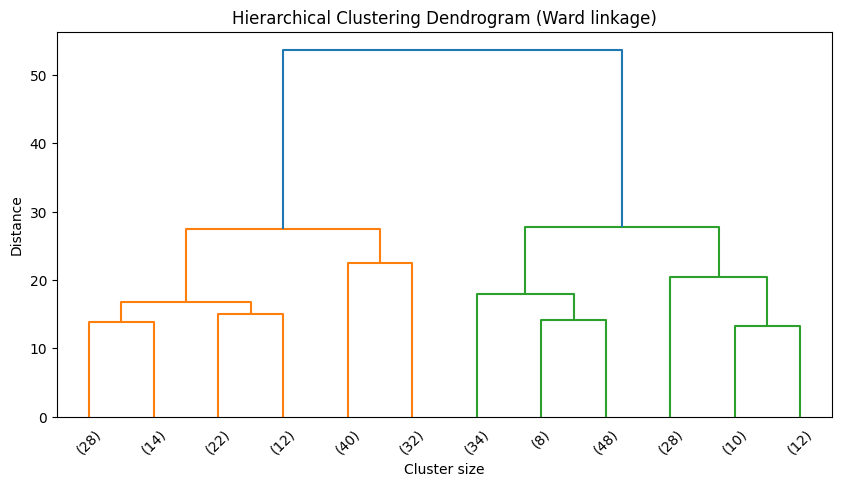

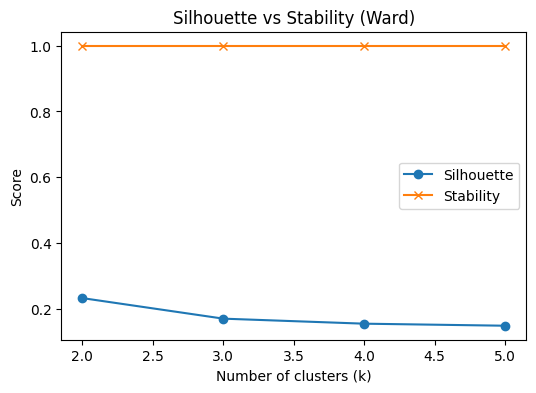

In [4]:
results = []

for ticker in ['SPY', 'QQQ']:
    for method in ['kmeans', 'ward']:
        for n_components in [0, 0.3, 0.5, 0.7, 0.9]:
            print(f"\nRunning {method.upper()} with {'PCA_' + str(n_components) if n_components > 0 else 'no PCA'}")
            result = regime_discovery(ticker, pca_n_components=n_components, method=method)
            results.append(result)

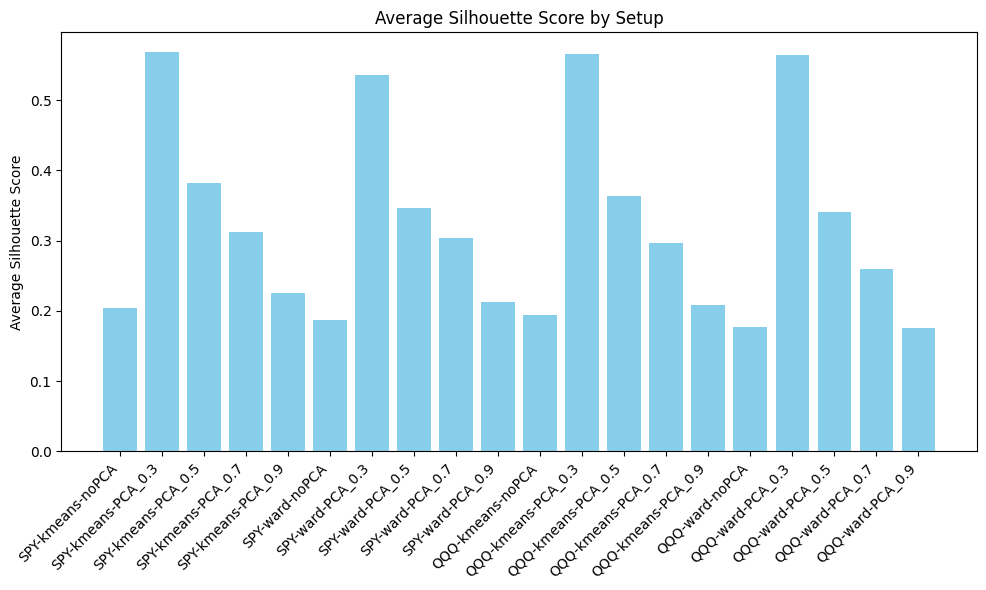

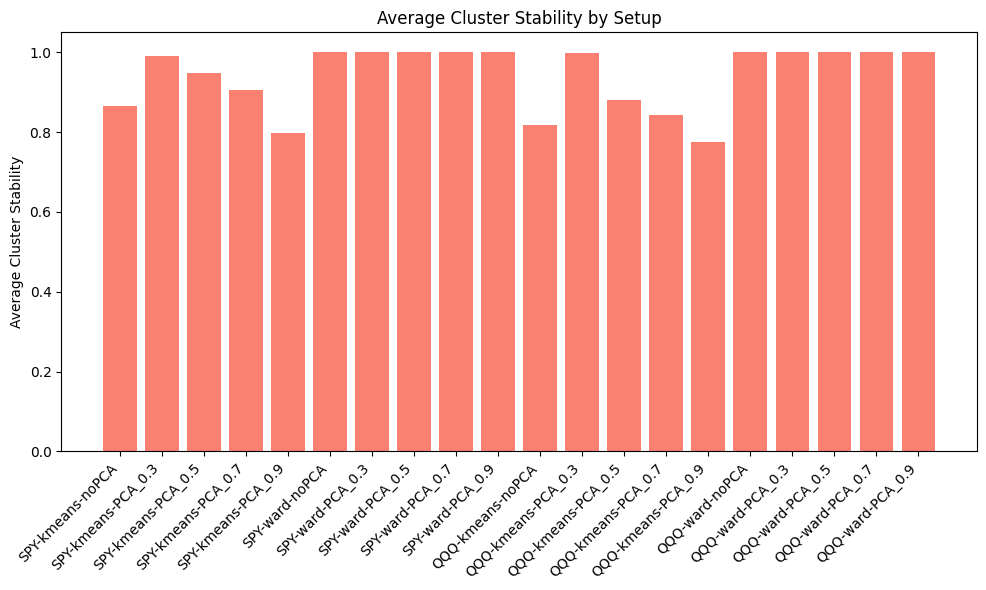

In [5]:
# Prepare data
labels = []
silhouette_avgs = []
stability_avgs = []

for r in results:
    label = f"{r['ticker']}-{r['method']}-{'PCA_' + str(r['nComponents']) if r['nComponents'] > 0 else 'noPCA'}"
    labels.append(label)

    # Silhouette average
    sil = [s for s in r['silhouettes'] if s is not None]
    silhouette_avgs.append(np.mean(sil) if sil else 0)

    # Stability average
    stab = [s for s in r['stabilities'] if s is not None]
    stability_avgs.append(np.mean(stab) if stab else 0)

x = np.arange(len(labels))

# 🎯 Silhouette Score Chart
plt.figure(figsize=(10, 6))
plt.bar(x, silhouette_avgs, color='skyblue')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score by Setup')
plt.tight_layout()
plt.show()

# 🎯 Cluster Stability Chart
plt.figure(figsize=(10, 6))
plt.bar(x, stability_avgs, color='salmon')
plt.xticks(x, labels, rotation=45, ha='right')
plt.ylabel('Average Cluster Stability')
plt.title('Average Cluster Stability by Setup')
plt.tight_layout()
plt.show()


Silhouette Score: A higher score meansthat points are well matched to their own cluster, so clusters are tight and well-separated

Cluster Stability: A higher score means clusters are consistently formed across different samples, so the method is reliable and robust

Kmeans with PCA 0.3 seems to have an overall high silhouette score and relatively balanced stability score

3 seems to be a reasonable best_k for the k-means lookinhg at the elnbow for the silhouette charts, and the ward linkage dendogram seems ot confirm same as well

__K-means clustering for best_k=3 and PCA = 0.3 nCompnents and Kmeans__

In [6]:
spy_result = regime_discovery(ticker='SPY', method='kmeans', pca_n_components=0.3, best_k=3, compute_stabilities=False)
spy_scaled_features_df = spy_result['features']
spy_features_df = spy_result['raw_features']
spy_features_df.loc[spy_scaled_features_df.index, 'regime'] = spy_result['labels']
spy_features_df.sample(7)

initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
23,2023-03-01,SPY,0.187576,0.037498,0.012868,0.086648,-0.008673,51.168284,-23.358624,-0.155997,...,-0.796059,-1.263428,-2.001598,-2.473949,-3.451444,-7.503490,-13.278715,-15.460890,-8.540808,2023
206,2023-04-17,SPY,0.144615,0.046449,0.018306,0.113950,0.045869,58.607628,-17.843269,0.158677,...,0.798820,1.165465,1.399080,2.720278,4.386168,5.484884,9.239547,15.591479,18.208460,2023
81,2023-05-23,SPY,0.175249,0.085071,-0.003644,0.128072,0.072176,56.428787,-22.873608,-0.494212,...,-2.492674,-3.622037,-4.256108,-4.084084,-1.858843,1.259070,2.584910,3.790220,5.410458,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.46512817])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_21d', 'price_diff_8d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
85,1.337897
285,-3.360565
274,2.235535



Results PCA_0.3 PCA using KMEANS clustering
K-means Silhouette: 0.5657601170824454
K-means CH Index: 823.1265852337916
K-means DB Index: 0.5201045357066543


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime
117,2023-07-17,SPY,0.125513,0.045329,0.014337,0.125267,0.154973,59.658743,-16.802449,0.180539,...,1.388960,1.985820,3.337150,6.762268,10.432215,12.308579,16.471454,23.201885,2023,2.0
83,2023-05-25,SPY,0.156543,0.094368,0.018991,0.140492,0.081198,55.261443,-25.252013,0.335074,...,2.292070,1.942012,-0.530974,-2.583176,-0.985831,2.785637,3.792217,5.218959,2023,0.0
274,2023-07-25,SPY,0.131429,0.059133,0.013155,0.123183,0.185283,59.119556,-22.342859,0.157960,...,1.267597,2.022934,2.923074,3.345453,4.814419,10.797339,18.222936,24.739099,2023,2.0
58,2023-04-20,SPY,0.159266,0.077128,0.014312,0.127854,0.034421,58.018087,-22.502624,-0.226108,...,-1.677645,-2.085412,-1.899827,-0.991941,1.369051,4.438584,9.880932,16.248005,2023,0.0
300,2023-08-30,SPY,0.130191,0.090684,0.020030,0.125074,0.100082,58.059644,-18.884124,0.260169,...,2.317515,4.728236,8.355307,10.705989,11.563302,9.308670,4.345032,3.935210,2023,2.0
115,2023-07-13,SPY,0.123555,0.036939,-0.001303,0.143103,0.175174,60.001251,-20.734341,0.413566,...,3.296273,5.225458,7.688420,9.540372,9.799782,11.689892,17.090150,23.758504,2023,2.0
213,2023-04-26,SPY,0.177792,0.082385,0.012842,0.131145,0.064053,57.933492,-25.252337,-0.232853,...,-2.108227,-4.440449,-6.942097,-8.284879,-8.185073,-6.202883,-0.698950,5.765638,2023,1.0


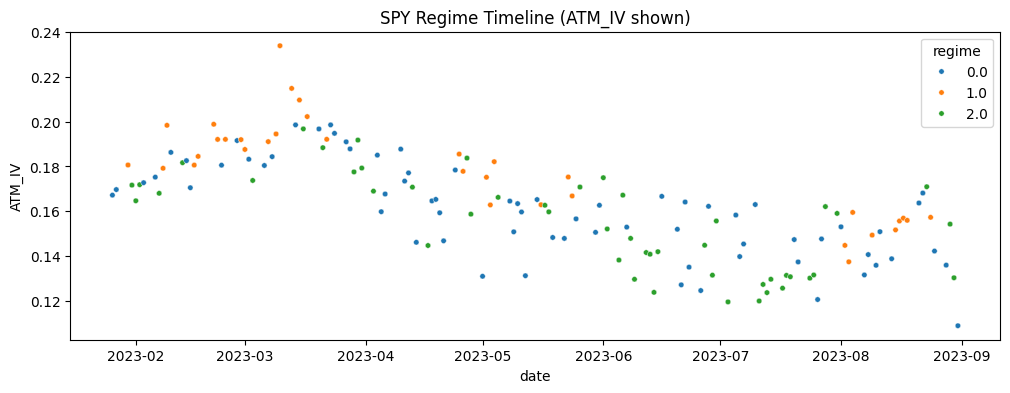

In [7]:
# Visualize regime transitions
plt.figure(figsize=(12, 4))
sns.scatterplot(data=spy_features_df, x='date', y='ATM_IV', hue='regime', palette='tab10', s=15)
plt.title("SPY Regime Timeline (ATM_IV shown)")
plt.show()

In [8]:
qqq_result = regime_discovery(ticker='QQQ', method='kmeans', pca_n_components=0.3, best_k=3, compute_stabilities=False)
qqq_scaled_features_df = qqq_result['features']
qqq_features_df = qqq_result['raw_features']
qqq_features_df.loc[qqq_scaled_features_df.index, 'regime'] = qqq_result['labels']
qqq_features_df.sample(7)

initial dataframe


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_5d,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year
142,2023-08-30,QQQ,0.183286,0.056109,0.010145,0.094368,0.104865,47.405381,-22.328314,0.408123,...,2.050797,4.285667,8.032665,12.006953,12.872541,12.368789,9.108359,4.565480,11.358407,2023
242,2023-06-28,QQQ,0.196796,0.035039,-0.008739,0.148575,0.079214,49.211697,-20.055514,0.164623,...,0.830678,1.771494,3.078236,3.101868,0.097812,0.987622,8.522300,20.880686,41.188554,2023
39,2023-04-03,QQQ,0.222628,0.056715,0.001693,0.087923,0.166987,47.627637,-24.658030,-0.084085,...,-0.424365,0.337703,2.685889,7.108559,10.893222,11.703573,17.494805,25.497506,23.904205,2023



PCA applied: 1 components retained
Explained variance ratio per component:


array([0.43664298])


Top contributing features per component:
Component 1: ['price_diff_13d', 'price_diff_8d', 'price_diff_21d', 'price_diff_5d', 'price_diff_3d']
after applying pca


,PC1
66,0.965188
230,1.876662
252,5.739791



Results PCA_0.3 PCA using KMEANS clustering
K-means Silhouette: 0.5226255458977387
K-means CH Index: 700.3853765215891
K-means DB Index: 0.5829856187391317


,date,ticker,ATM_IV,Skew,Curvature,IV_std,Avg_Delta,Avg_Vega,Avg_Theta,price_diff_1d,...,price_diff_8d,price_diff_13d,price_diff_21d,price_diff_34d,price_diff_55d,price_diff_89d,price_diff_144d,price_diff_233d,year,regime
16,2023-03-01,QQQ,0.243869,0.074009,-0.002719,0.051516,-0.012904,43.002907,-28.674443,-0.290773,...,-2.052491,-2.429519,-2.321630,-3.894085,-7.799882,-14.186410,-11.559569,9.724938,2023,1.0
68,2023-05-15,QQQ,0.211365,0.061609,-0.002284,0.101919,0.083024,42.638537,-20.750729,0.242409,...,1.417552,1.604941,2.402176,4.936210,6.858371,8.727168,11.991505,18.558443,2023,0.0
137,2023-08-23,QQQ,0.201507,0.073514,0.010071,0.080427,0.055319,49.307863,-28.829187,0.831439,...,5.333614,6.745352,7.719217,5.792341,-0.039766,-3.859660,-5.579020,5.104559,2023,2.0
11,2023-02-22,QQQ,0.251583,0.074197,0.001184,0.054942,0.054227,44.982542,-33.122964,0.005656,...,-0.627610,-3.374034,-8.186626,-12.406423,-9.287436,-11.774718,1.716474,18.882942,2023,1.0
96,2023-06-26,QQQ,0.198679,0.041833,0.006294,0.119445,0.152098,49.675720,-24.606811,-0.718209,...,-5.120588,-6.577644,-7.279627,-7.392395,-4.705939,6.246295,16.613222,36.315694,2023,1.0
287,2023-08-31,QQQ,0.168168,0.089972,0.030941,0.127186,0.135669,48.536979,-24.294563,0.213569,...,2.137508,4.651809,9.074006,13.424440,13.064502,11.805716,6.066076,10.617990,2023,2.0
78,2023-05-30,QQQ,0.217429,0.043008,-0.010305,0.094954,0.185333,47.141045,-22.611918,0.262342,...,3.218943,7.650409,13.870807,16.282008,17.725359,26.343992,32.336018,39.658905,2023,2.0


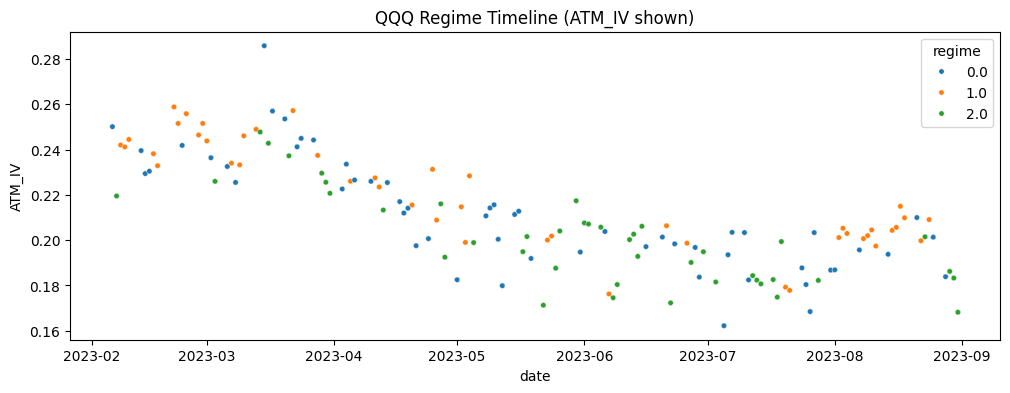

In [9]:
# Visualize regime transitions
plt.figure(figsize=(12, 4))
sns.scatterplot(data=qqq_features_df, x='date', y='ATM_IV', hue='regime', palette='tab10', s=15)
plt.title("QQQ Regime Timeline (ATM_IV shown)")
plt.show()

- Silhouette score - higher means better separation.
- Calinski–Harabasz index → higher means more distinct clusters.
- Davies–Bouldin index → lower means better separation. 

,ATM_IV,Skew,Curvature
regime,,,
0.0,0.160360,0.062408,0.005659
1.0,0.178832,0.065425,0.006653
2.0,0.153844,0.058086,0.003704


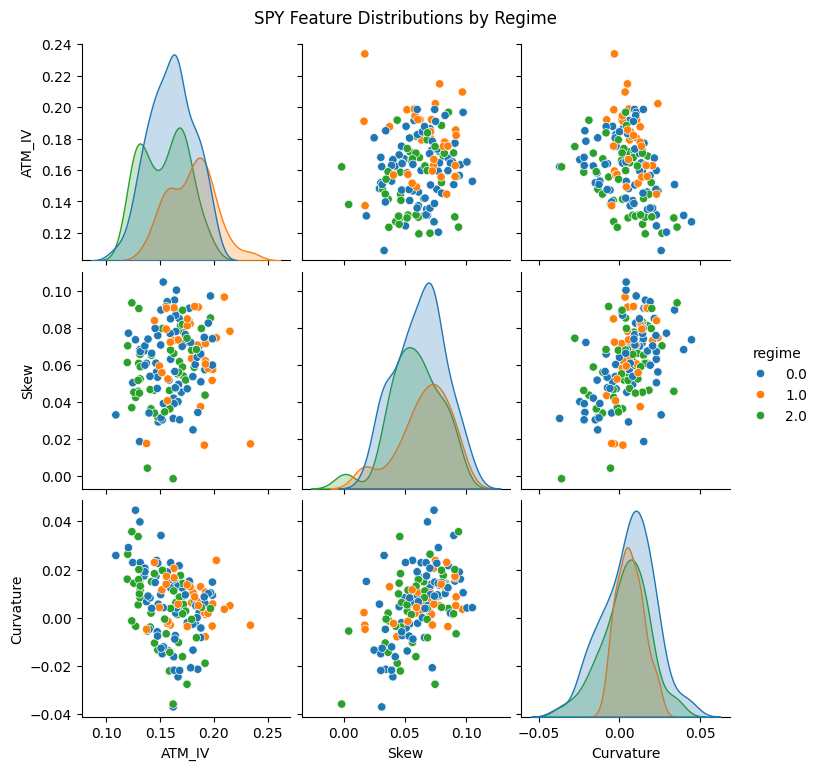

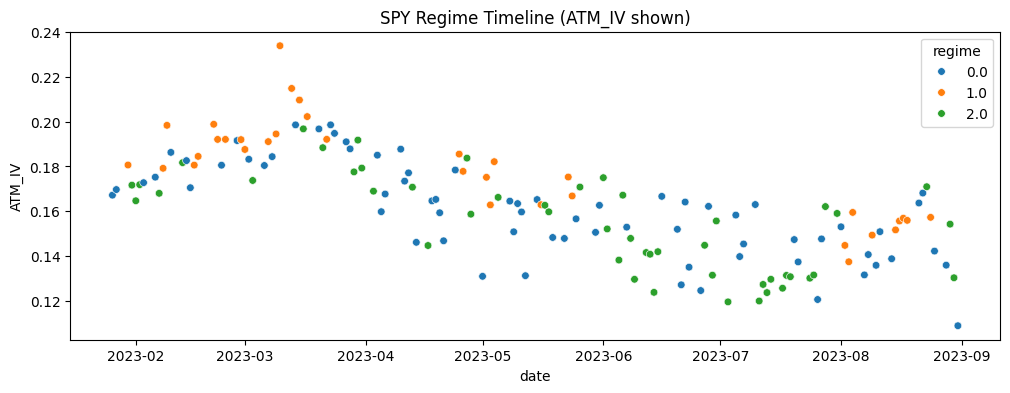

In [16]:
# ============================================
# 8. Profile regimes for SPY
# ============================================
# We compute average ATM_IV, Skew, Curvature per regime and plot timelines.
regime_k_spy = spy_features_df.groupby('regime')[['ATM_IV', 'Skew', 'Curvature']].mean()
display(regime_k_spy)

sns.pairplot(spy_features_df, vars=['ATM_IV', 'Skew', 'Curvature'], hue='regime', palette='tab10')
plt.suptitle("SPY Feature Distributions by Regime", y=1.02)
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(data=spy_features_df, x='date', y='ATM_IV', hue='regime', palette='tab10', s=30)
plt.title("SPY Regime Timeline (ATM_IV shown)")
plt.show()

,ATM_IV,Skew,Curvature
regime,,,
0.0,0.211210,0.061497,0.005400
1.0,0.220378,0.060932,0.006008
2.0,0.199738,0.061784,0.007759


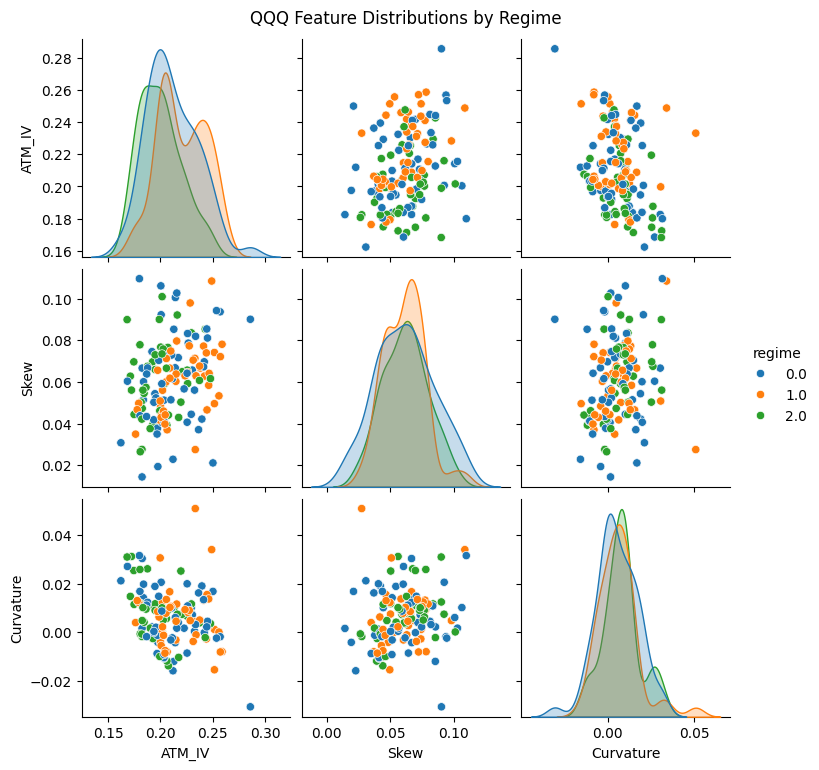

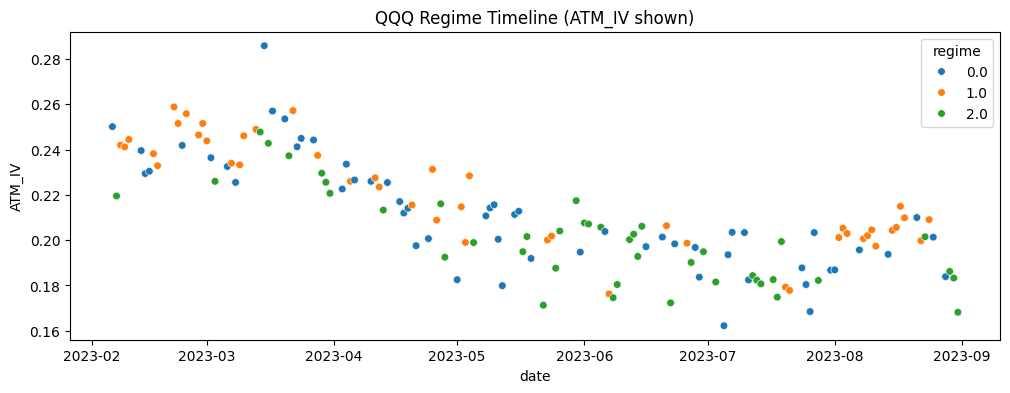

In [17]:
# ============================================
# 8. Profile regimes for QQQ
# ============================================
# We compute average ATM_IV, Skew, Curvature per regime and plot timelines.
regime_k_qqq = qqq_features_df.groupby('regime')[['ATM_IV', 'Skew', 'Curvature']].mean()
display(regime_k_qqq)

sns.pairplot(qqq_features_df, vars=['ATM_IV', 'Skew', 'Curvature'], hue='regime', palette='tab10')
plt.suptitle("QQQ Feature Distributions by Regime", y=1.02)
plt.show()

plt.figure(figsize=(12, 4))
sns.scatterplot(data=qqq_features_df, x='date', y='ATM_IV', hue='regime', palette='tab10', s=30)
plt.title("QQQ Regime Timeline (ATM_IV shown)")
plt.show()

The pair plot shows how ATM_IV, Skew, and Curvature differ across the 3 regimes, with histograms revealing distinct feature ranges per regime and scatter plots showing regime‑specific relationships. The time series plot maps these regimes over time, revealing periods of persistence and transitions. Multiple regimes on the same day occur because clustering is applied to individual observations, which can vary intraday or across instruments, leading to different regime assignments within the same calendar date.

__Save to Parquet: We persist the dataset with regime labels for downstream modeling.__

In [12]:
spy_features_df.to_parquet("daily_spy_features_with_regimes.parquet", index=False)

In [13]:
qqq_features_df.to_parquet("daily_qqq_features_with_regimes.parquet", index=False)